# Learning Jammers: Loss Simulations
In this notebook, we will simulate different losses, compare their performance (BER) and have a look at their learned weights.

### Evaluation of different Losses

In [2]:
import os
# import drjit
gpu_num = 6 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sionna
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')
# tf.config.run_functions_eagerly(True)

from jammer.simulation_model import *
import jammer.simulation_model as sim
from tensorflow.python.keras.losses import MeanAbsoluteError, MeanSquaredError, BinaryCrossentropy

In [3]:
# common parameters
model_parameters = {}
jammer_parameters = {}
model_parameters["perfect_csi"] = False
model_parameters["num_ut"] = 1
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = 1.0
model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = 1
model_parameters["num_silent_pilot_symbols"] = 4
jammer_parameters["trainable"] = True
model_parameters["jammer_parameters"] = jammer_parameters

In [4]:
# needed, as keras MSE does not take |.|
abs_mse = lambda y_true, y_pred: tf.reduce_mean(tf.square(tf.abs(y_true - y_pred)))
abs_log = lambda y_true, y_pred: tf.reduce_mean(tf.math.log(tf.abs(y_true - y_pred) + 1))
# name, loss_fn, over symbols?, loss_over_logits
parameters = [
    ("L1 over symbols", negative_function(MeanAbsoluteError()), True, False),
    ("MSE over symbols", negative_function(abs_mse), True, False),
    ("L1 over bit estimates", negative_function(MeanAbsoluteError()), False, False),
    ("MSE over bit estimates", negative_function(MeanSquaredError()), False, False),
    ("BCE over bit estimates (logits)", BinaryCrossentropy(from_logits=True), False, True),
    ("log over bit estimates", negative_function(abs_log), False, False),
]

In [ ]:
sim.BATCH_SIZE = 2
for name, loss_fn, over_symbols, loss_over_logits in parameters:
    model = Model(**model_parameters, return_symbols=over_symbols)
    train_model(model,
                loss_fn=loss_fn,
                loss_over_logits=loss_over_logits,
                weights_filename=f"weights/{name}.pickle",
                log_tensorboard=True,
                log_weight_images=True,
                show_final_weights=True)

In [4]:
sim.MAX_MC_ITER = 150
sim.BATCH_SIZE = 16
# exclude BCE, as it is too bad
parameters = [x for x in parameters if "BCE" not in x[0]]
model_parameters["return_symbols"] = False
jammer_parameters["trainable"] = False
for name, loss_fn, over_symbols, loss_over_logits in parameters:
    filename = f"weights/{name}.pickle"
    model = Model(**model_parameters)
    load_weights(model, filename)
    simulate_model(model, name, add_bler=True)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.3894e-01 | 1.0000e+00 |     1321246 |     5529600 |         2400 |        2400 |        17.3 |reached max iter       
   -3.571 | 2.1259e-01 | 1.0000e+00 |     1175549 |     5529600 |         2400 |        2400 |        11.7 |reached max iter       
   -2.143 | 1.9354e-01 | 1.0000e+00 |     1070214 |     5529600 |         2400 |        2400 |        11.8 |reached max iter       
   -0.714 | 1.7121e-01 | 1.0000e+00 |      946728 |     5529600 |         2400 |        2400 |        11.9 |reached max iter       
    0.714 | 1.5737e-01 | 1.0000e+00 |      870208 |     5529600 |         2400 |        2400 |        12.3 |reached max iter       
    2.143 | 1.4722e-01 | 1.0000e+00 |      814053 |     5529600 |         2400 |     

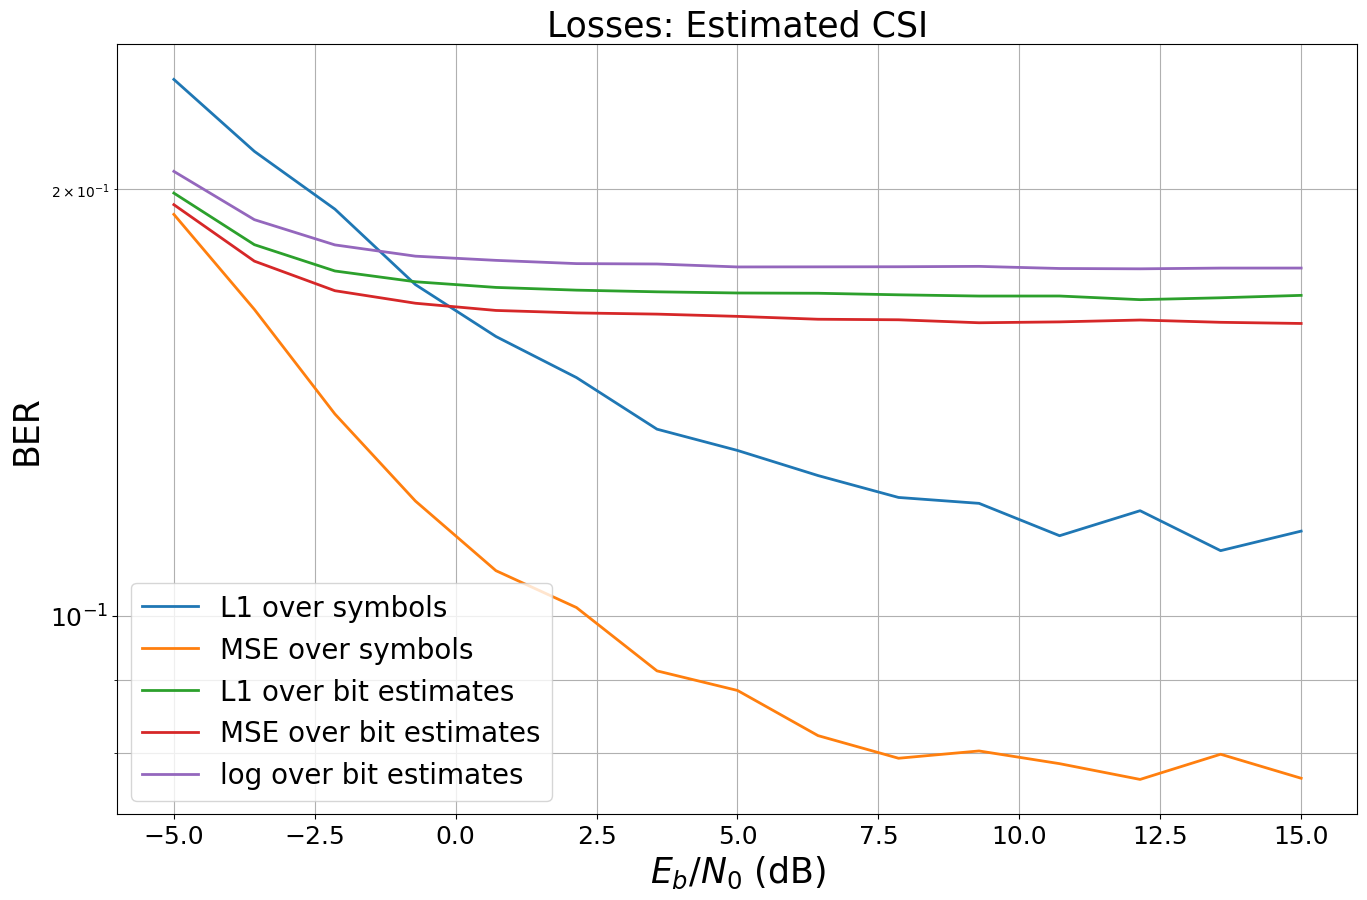

In [6]:
ber_plots.title = "Losses: Estimated CSI"
ber_plots(show_bler=False)

### L1 Loss over Symbol Error, Different Constellation Sizes

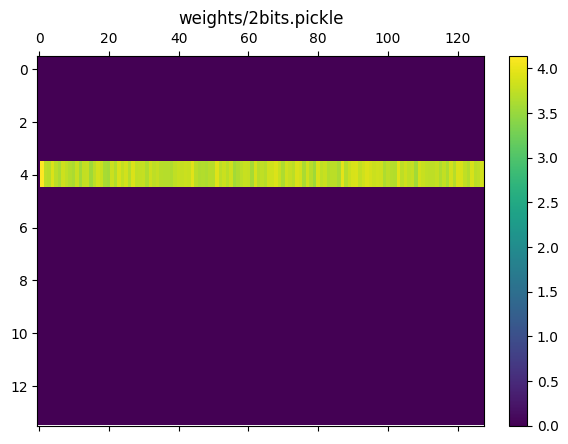

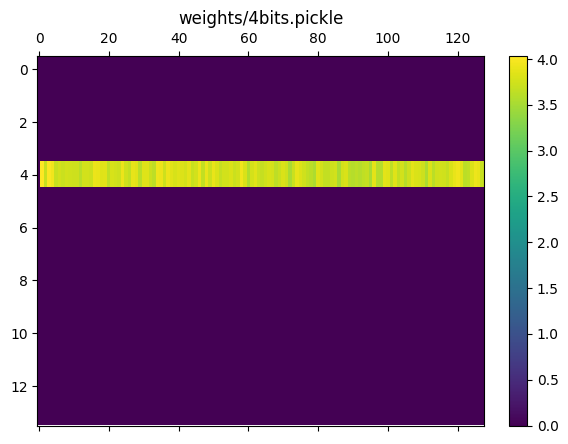

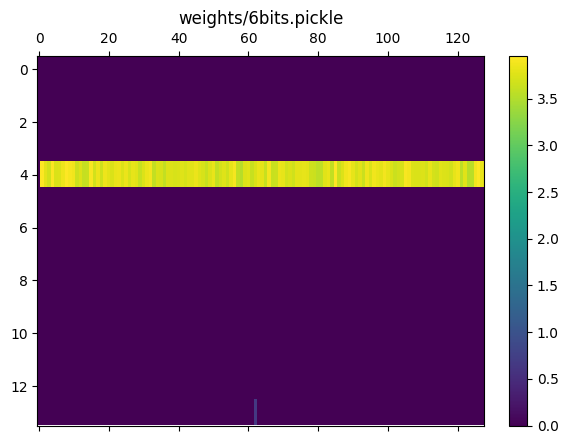

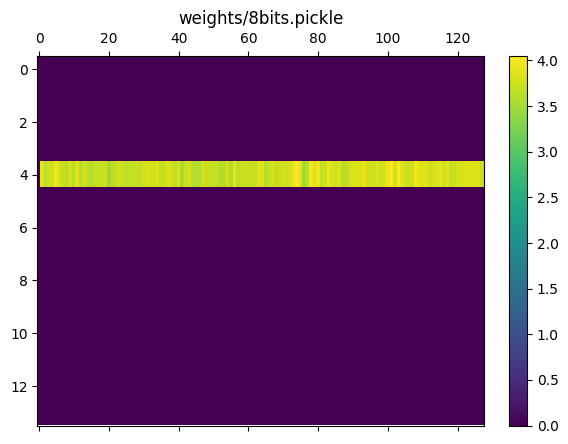

In [3]:
sim.BATCH_SIZE = 2
loss = negative_function(MeanAbsoluteError())
jammer_parameters["trainable"] = True
# 4, 16, 64, 256 - QAM
bits_per_symbol = [2, 4, 6, 8]
for b in bits_per_symbol:
    model = Model(**model_parameters, num_bits_per_symbol=b, return_symbols=True)
    train_model(model,
                loss_fn=loss,
                loss_over_logits=False,
                weights_filename=f"weights/{b}bits.pickle",
                log_tensorboard=True,
                log_weight_images=True,
                show_final_weights=True,
                num_iterations=2000)

### Training L1-bit-error on different SNRs

In [ ]:
sim.BATCH_SIZE = 2
loss = negative_function(MeanAbsoluteError())
snrs = np.arange(-5, 10.5, 2.5, dtype=np.float32)
jammer_parameters["trainable"] = True
for ebno_db in snrs:
    model = Model(**model_parameters)
    train_model(model,
                loss_fn=loss,
                loss_over_logits=False,
                weights_filename=f"weights/{ebno_db}db.pickle",
                log_tensorboard=True,
                log_weight_images=True,
                show_final_weights=True,
                num_iterations=2000,
                ebno_db=ebno_db)

In [7]:
sim.MAX_MC_ITER = 150
sim.BATCH_SIZE = 16
jammer_parameters["trainable"] = False
for ebno_db in snrs:
    filename = f"weights/{ebno_db}db.pickle"
    model = Model(**model_parameters)
    load_weights(model, filename)
    simulate_model(model, f"{ebno_db}db")

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.3775e-01 | 1.0000e+00 |     1867644 |     5529600 |         2400 |        2400 |        23.2 |reached max iter       
   -3.571 | 3.3296e-01 | 1.0000e+00 |     1841163 |     5529600 |         2400 |        2400 |        13.1 |reached max iter       
   -2.143 | 3.3045e-01 | 1.0000e+00 |     1827233 |     5529600 |         2400 |        2400 |        13.2 |reached max iter       
   -0.714 | 3.2784e-01 | 1.0000e+00 |     1812805 |     5529600 |         2400 |        2400 |        12.9 |reached max iter       
    0.714 | 3.2783e-01 | 1.0000e+00 |     1812784 |     5529600 |         2400 |        2400 |        13.2 |reached max iter       
    2.143 | 3.2634e-01 | 1.0000e+00 |     1804507 |     5529600 |         2400 |     

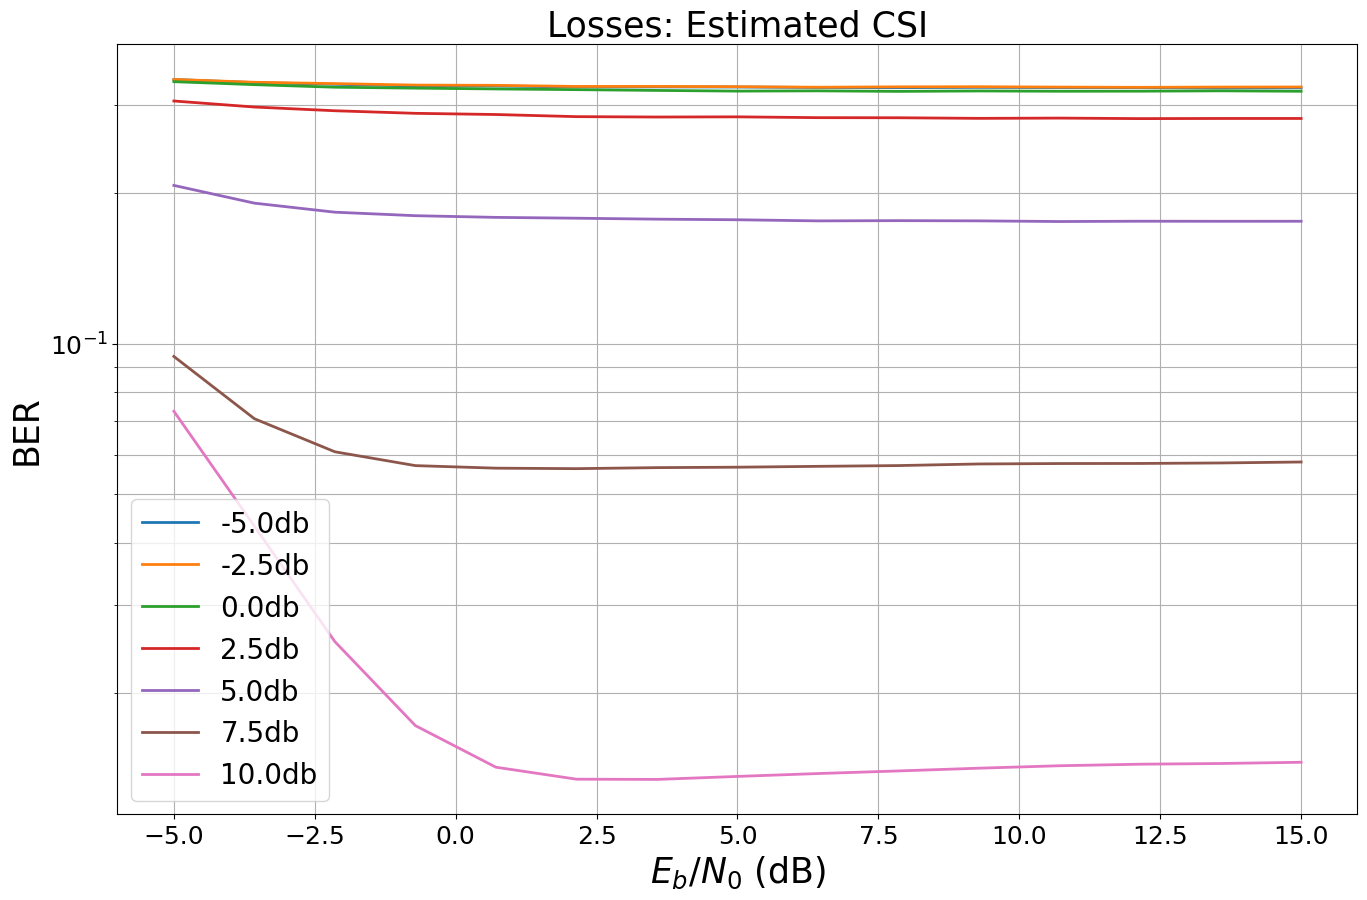

In [8]:
ber_plots.title = "Losses: Estimated CSI"
ber_plots()

### Problem Fixing

We tried to improve this by "fixing" the dying ReLU problem. Below is the same training, but using MaxMeanSquareNorm instead of NonNegMaxMeanSquareNorm.

In [9]:
sim.MAX_MC_ITER = 150
sim.BATCH_SIZE = 16
jammer_parameters["trainable"] = False
jammer_parameters["trainable_mask"] = tf.ones([14, 128])
snrs = np.arange(-5, 10.5, 2.5, dtype=np.float32)
for ebno_db in snrs:
    filename = f"weights/{ebno_db}dB_relufix.pickle"
    model = Model(**model_parameters)
    load_weights(model, filename)
    simulate_model(model, f"{ebno_db}db")

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.3777e-01 | 1.0000e+00 |     1867752 |     5529600 |         2400 |        2400 |        16.4 |reached max iter       
   -3.571 | 3.3364e-01 | 1.0000e+00 |     1844922 |     5529600 |         2400 |        2400 |        11.1 |reached max iter       
   -2.143 | 3.3082e-01 | 1.0000e+00 |     1829316 |     5529600 |         2400 |        2400 |        10.9 |reached max iter       
   -0.714 | 3.2806e-01 | 1.0000e+00 |     1814020 |     5529600 |         2400 |        2400 |        11.0 |reached max iter       
    0.714 | 3.2717e-01 | 1.0000e+00 |     1809141 |     5529600 |         2400 |        2400 |        11.1 |reached max iter       
    2.143 | 3.2519e-01 | 1.0000e+00 |     1798144 |     5529600 |         2400 |     

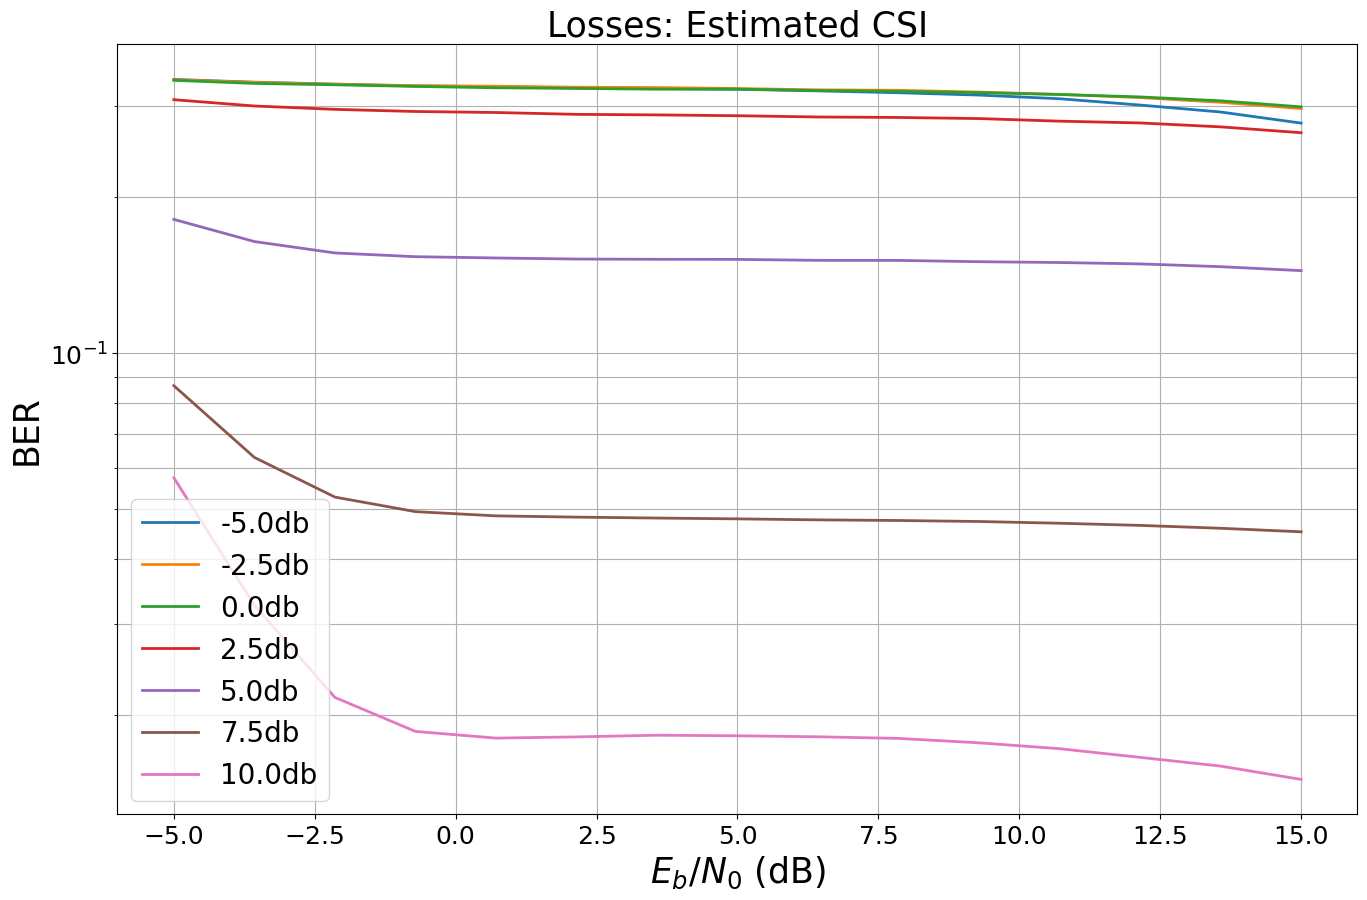

In [16]:
ber_plots.title = "Losses: Estimated CSI"
ber_plots(show_bler=False)

We trained using the NonNegMaxSquareNorm constraint as variable-constraint instead of integrated into the network.

In [5]:
sim.MAX_MC_ITER = 150
sim.BATCH_SIZE = 16
jammer_parameters["trainable"] = False
jammer_parameters["trainable_mask"] = tf.ones([14, 128])
snrs = np.arange(-2.5, 10.5, 2.5, dtype=np.float32)
for ebno_db in snrs:
    filename = f"weights/{ebno_db}dB_constraint.pickle"
    model = Model(**model_parameters)
    load_weights(model, filename)
    simulate_model(model, f"{ebno_db}db")

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.2799e-01 | 1.0000e+00 |     1813631 |     5529600 |         2400 |        2400 |        17.4 |reached max iter       
   -3.571 | 3.2405e-01 | 1.0000e+00 |     1791862 |     5529600 |         2400 |        2400 |        11.7 |reached max iter       
   -2.143 | 3.2171e-01 | 1.0000e+00 |     1778955 |     5529600 |         2400 |        2400 |        11.8 |reached max iter       
   -0.714 | 3.1991e-01 | 1.0000e+00 |     1768972 |     5529600 |         2400 |        2400 |        11.9 |reached max iter       
    0.714 | 3.1805e-01 | 1.0000e+00 |     1758675 |     5529600 |         2400 |        2400 |        11.9 |reached max iter       
    2.143 | 3.1619e-01 | 1.0000e+00 |     1748407 |     5529600 |         2400 |     

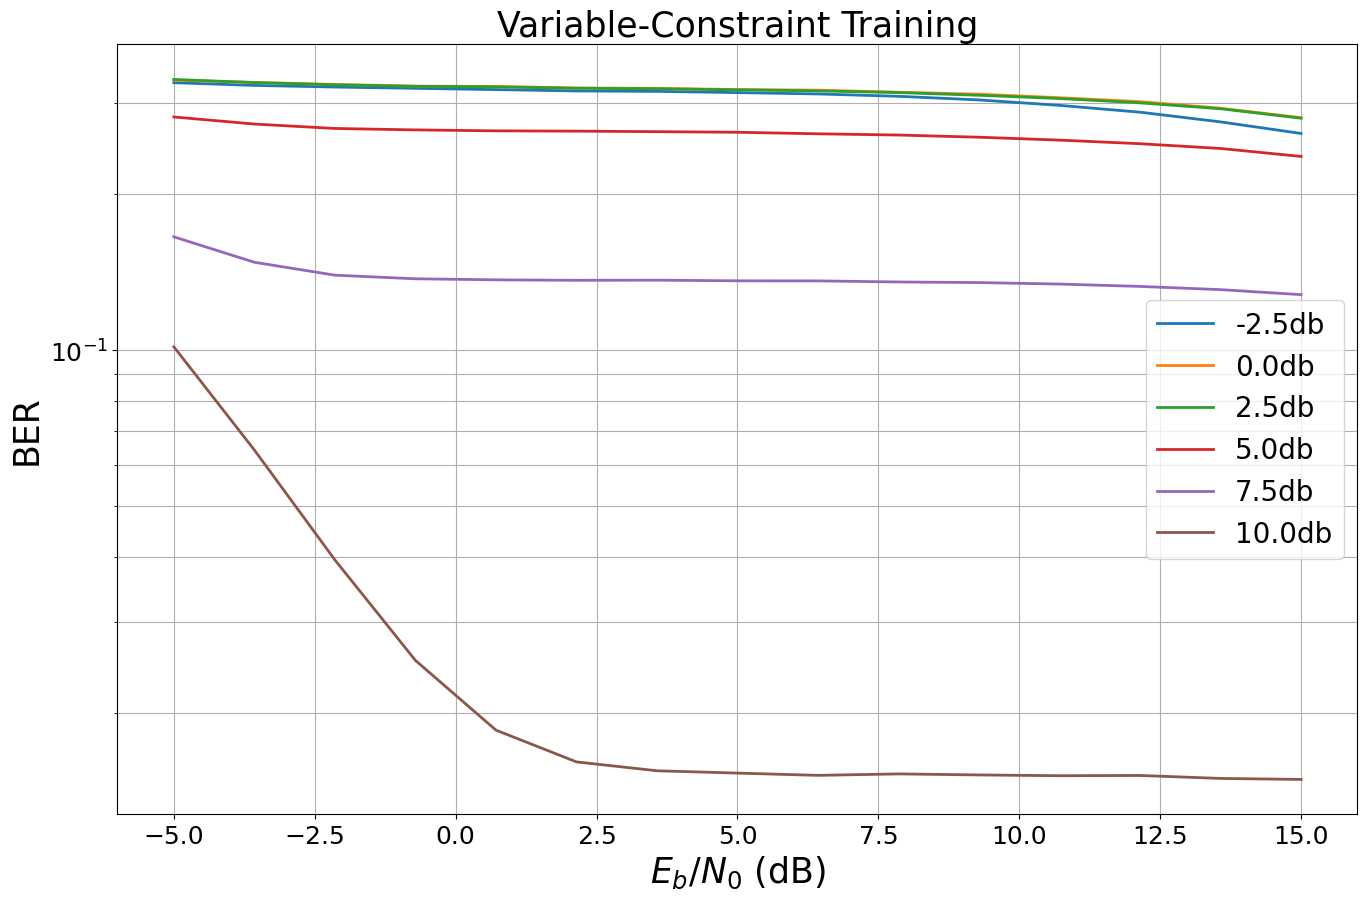

In [7]:
ber_plots.title = "Variable-Constraint Training"
ber_plots()

### Different number of UEs

In [10]:
sim.MAX_MC_ITER = 150
sim.BATCH_SIZE = 4
jammer_parameters["trainable"] = False
jammer_parameters["trainable_mask"] = tf.ones([14, 128])
num_ues = np.arange(1, 5, dtype=np.int32)
for num_ue in num_ues:
    filename = f"weights/ue_{num_ue}_relufix.pickle"
    model = Model(**{**model_parameters, "num_ut": num_ue})
    load_weights(model, filename)
    simulate_model(model, f"{num_ue} UE(s), integrated")
for num_ue in num_ues:
    filename = f"weights/ue_{num_ue}_constraint.pickle"
    model = Model(**{**model_parameters, "num_ut": num_ue})
    load_weights(model, filename)
    simulate_model(model, f"{num_ue} UE(s), variable constraint")

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.2812e-01 | 1.0000e+00 |      453587 |     1382400 |          600 |         600 |        19.0 |reached max iter       
   -3.571 | 3.2322e-01 | 1.0000e+00 |      446824 |     1382400 |          600 |         600 |         7.9 |reached max iter       
   -2.143 | 3.2005e-01 | 1.0000e+00 |      442436 |     1382400 |          600 |         600 |         8.9 |reached max iter       
   -0.714 | 3.1651e-01 | 1.0000e+00 |      437540 |     1382400 |          600 |         600 |         9.5 |reached max iter       
    0.714 | 3.1368e-01 | 1.0000e+00 |      433635 |     1382400 |          600 |         600 |         9.8 |reached max iter       
    2.143 | 3.1206e-01 | 1.0000e+00 |      431390 |     1382400 |          600 |     

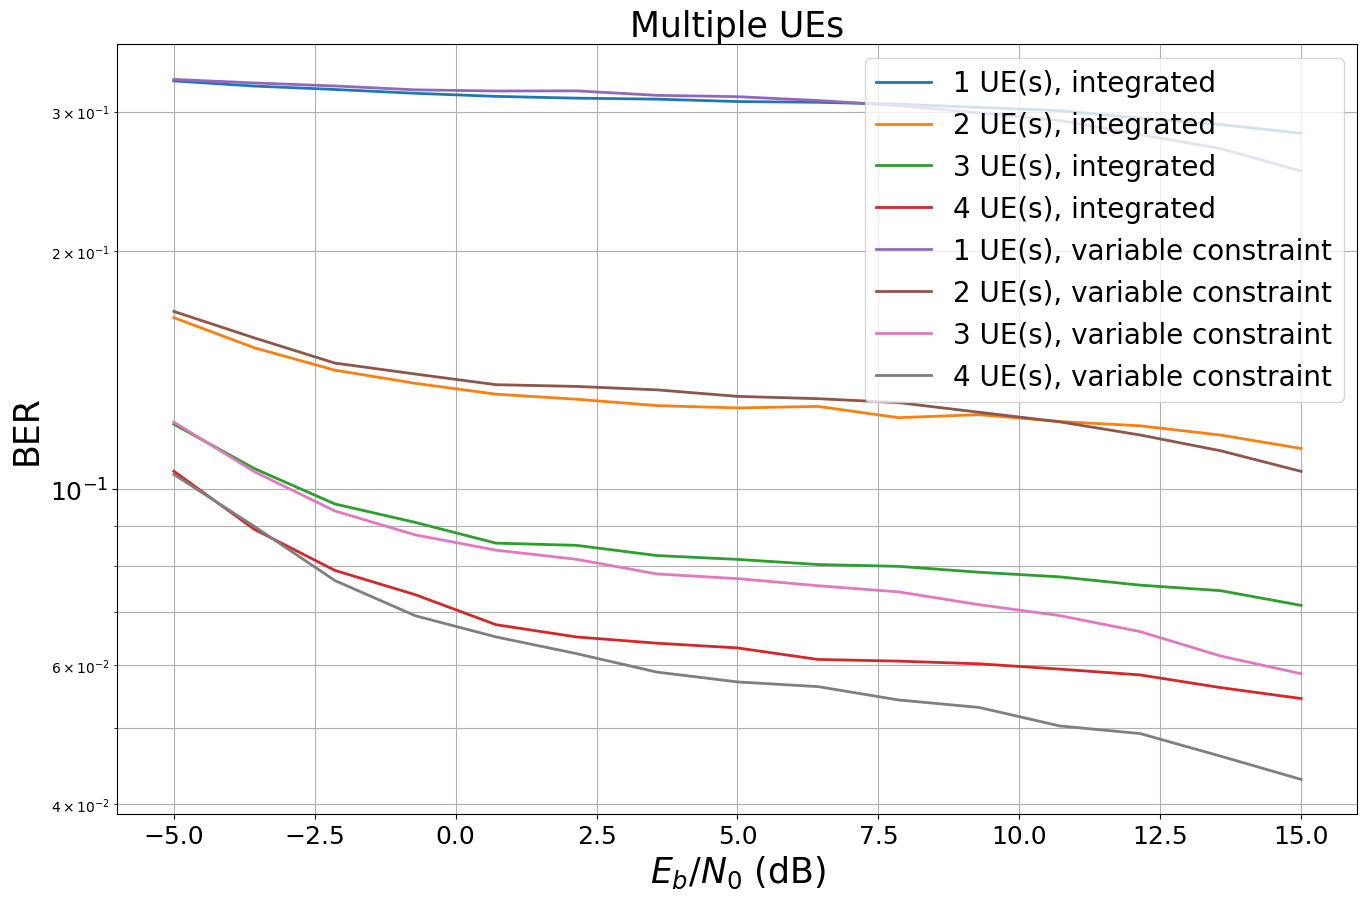

In [23]:
ber_plots.title = "Multiple UEs"
ber_plots()

In [25]:
for num_ue in num_ues:
    filename = f"weights/ue_{num_ue}_relufix_constraint.pickle"
    model = Model(**{**model_parameters, "num_ut": num_ue})
    load_weights(model, filename)
    # c.b.n: can be negative
    simulate_model(model, f"{num_ue} UE(s), variable constraint (c.b.n.)")

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.2631e-01 | 1.0000e+00 |      451086 |     1382400 |          600 |         600 |        20.5 |reached max iter       
   -3.571 | 3.2125e-01 | 1.0000e+00 |      444102 |     1382400 |          600 |         600 |        14.7 |reached max iter       
   -2.143 | 3.1823e-01 | 1.0000e+00 |      439927 |     1382400 |          600 |         600 |        14.7 |reached max iter       
   -0.714 | 3.1430e-01 | 1.0000e+00 |      434484 |     1382400 |          600 |         600 |        14.7 |reached max iter       
    0.714 | 3.1179e-01 | 1.0000e+00 |      431020 |     1382400 |          600 |         600 |        15.4 |reached max iter       
    2.143 | 3.0882e-01 | 1.0000e+00 |      426915 |     1382400 |          600 |     

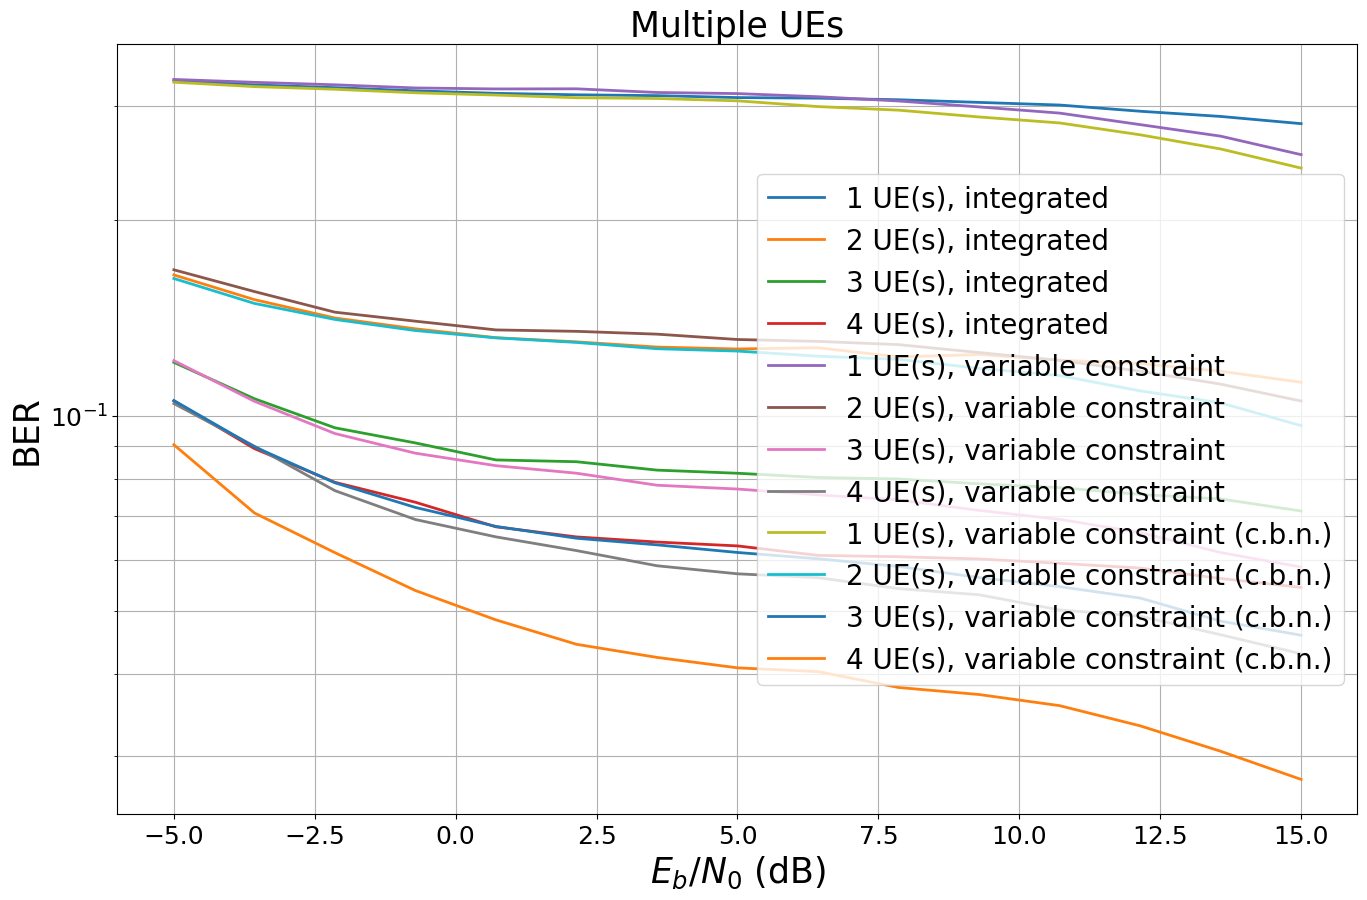

In [26]:
ber_plots.title = "Multiple UEs"
ber_plots()

### Training over Symbol Time only (14 Parameters, at 0dB ebno_db)
The following losses were all only trained over Symbols (one weight per symbol-time) only, and at 0dB UE-BS SNR

In [6]:
sim.MAX_MC_ITER = 150
sim.BATCH_SIZE = 16
# exclude BCE, as it is too bad
parameters = [x for x in parameters if "BCE" not in x[0]]
model_parameters["return_symbols"] = False
jammer_parameters["trainable"] = False
jammer_parameters["trainable_mask"] = tf.ones([14, 1], dtype=tf.bool)
for name, loss_fn, over_symbols, loss_over_logits in parameters:
    filename = f"weights/{name} symbol_weights.pickle"
    model = Model(**model_parameters)
    load_weights(model, filename)
    simulate_model(model, name)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.3670e-01 | 1.0000e+00 |     1308834 |     5529600 |         2400 |        2400 |        17.4 |reached max iter       
   -3.571 | 2.1369e-01 | 1.0000e+00 |     1181640 |     5529600 |         2400 |        2400 |        11.0 |reached max iter       
   -2.143 | 1.8991e-01 | 1.0000e+00 |     1050103 |     5529600 |         2400 |        2400 |        11.0 |reached max iter       
   -0.714 | 1.7140e-01 | 1.0000e+00 |      947753 |     5529600 |         2400 |        2400 |        11.1 |reached max iter       
    0.714 | 1.5664e-01 | 1.0000e+00 |      866167 |     5529600 |         2400 |        2400 |        11.0 |reached max iter       
    2.143 | 1.4572e-01 | 1.0000e+00 |      805796 |     5529600 |         2400 |     

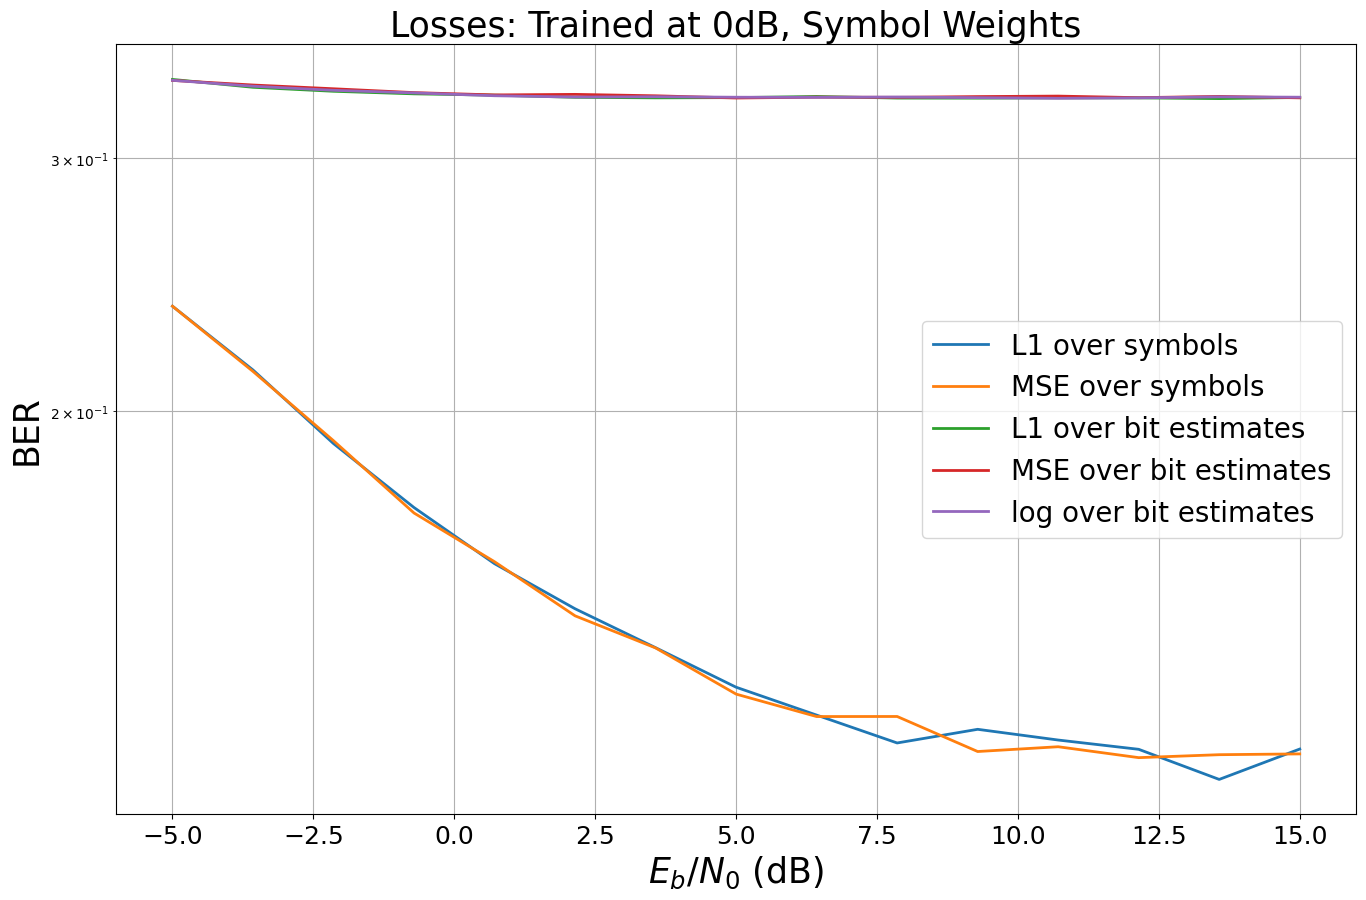

In [7]:
ber_plots.title = "Losses: Trained at 0dB, Symbol Weights"
ber_plots()

### Training over Non-silent Symbols only
To maybe prevent local maximum we are sliding into when learning to not jam silent symbols